# GBMap Raw UMAP Plot

Current working directory: /root/Cycle/Github
Loading data...
           author assay_ontology_term_id cell_type_ontology_term_id  \
PJ017_0  Yuan2018            EFO:0030002                 CL:0001064   
PJ017_1  Yuan2018            EFO:0030002                 CL:0001064   
PJ017_2  Yuan2018            EFO:0030002                 CL:0000235   
PJ017_3  Yuan2018            EFO:0030002                 CL:0001064   
PJ017_4  Yuan2018            EFO:0030002                 CL:0001064   

        development_stage_ontology_term_id disease_ontology_term_id  \
PJ017_0                     HsapDv:0000156            MONDO:0018177   
PJ017_1                     HsapDv:0000156            MONDO:0018177   
PJ017_2                     HsapDv:0000156            MONDO:0018177   
PJ017_3                     HsapDv:0000156            MONDO:0018177   
PJ017_4                     HsapDv:0000156            MONDO:0018177   

        self_reported_ethnicity_ontology_term_id  is_primary_data  \
PJ017_0        

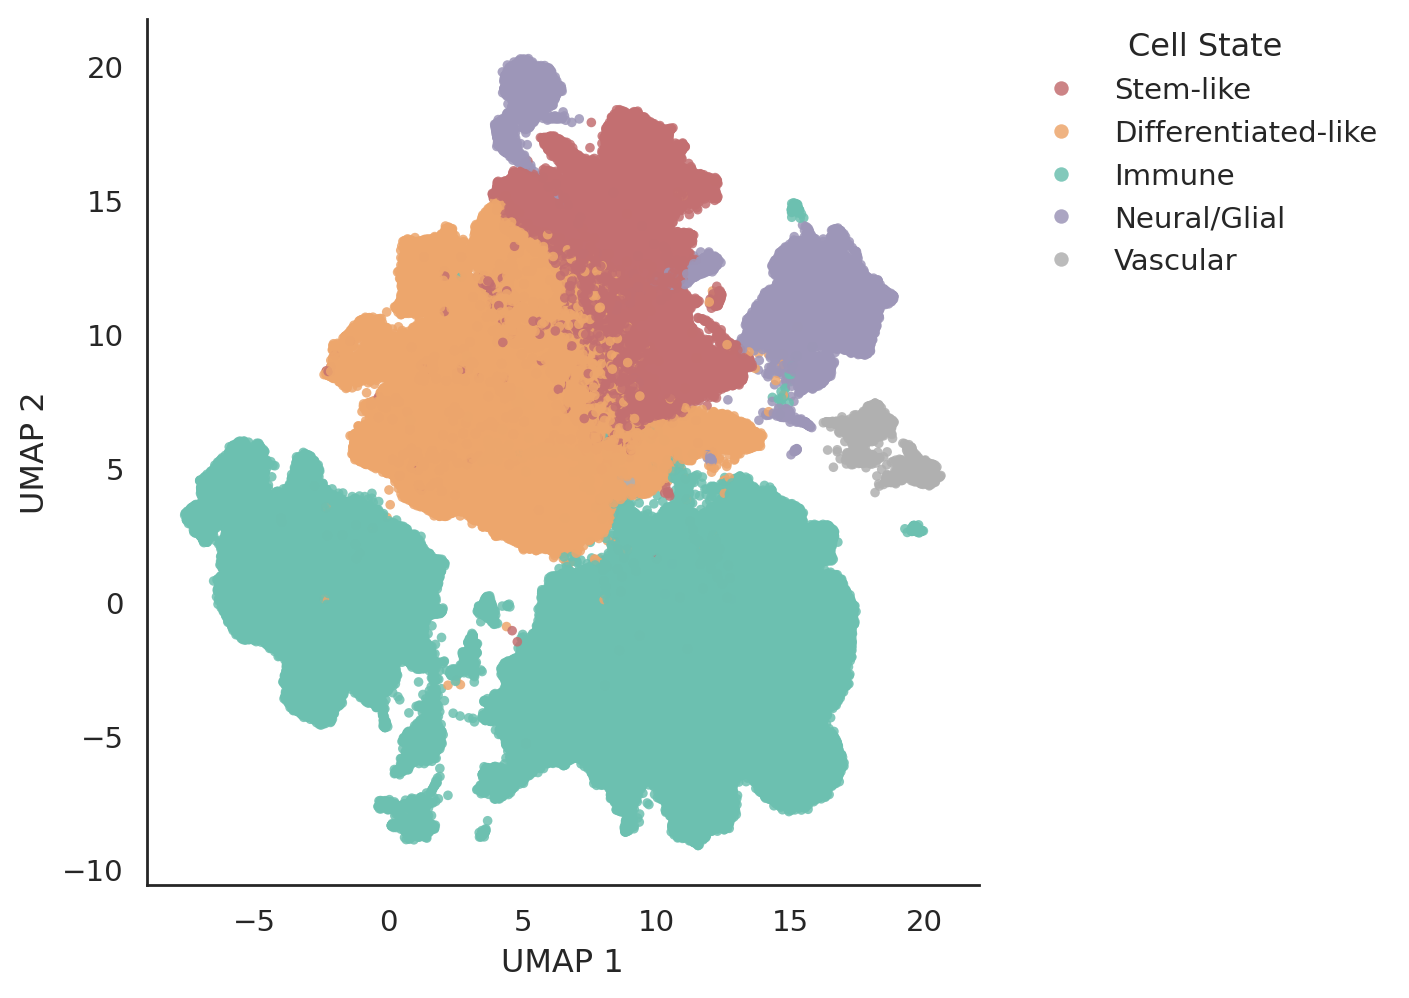

In [2]:
import os
import sys
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================
# Modification: Change Matplotlib Backend
# ==============================
# 'notebook' mode often fails in remote/headless environments.
# 'inline' is the most stable option for static plots in Jupyter.
%matplotlib inline 

# Set high-resolution display (Retina optimization for clearer plots)
%config InlineBackend.figure_format = 'retina'

# ==============================
# 1. Setup Environment
# ==============================
# Set working directory to project root
os.chdir("/root/Cycle/Github")
print("Current working directory:", os.getcwd())

# Add custom module path if needed
sys.path.append("./HarmoCycle/")

# ==============================
# 2. Load Data and Process Coordinates
# ==============================
# Load AnnData
print("Loading data...")
adata = sc.read_h5ad('./Dataset/GBMap-Raw.h5ad')

# Copy metadata (obs)
obs_df = adata.obs.copy()

# Extract UMAP coordinates into a DataFrame
umap_df = pd.DataFrame(
    adata.obsm['X_umap'],
    index=adata.obs.index,
    columns=['UMAP1', 'UMAP2']
)

# Merge metadata with UMAP coordinates
merged_df = pd.concat([obs_df, umap_df], axis=1)

# Check first few rows
print(merged_df.head())

# ==============================
# 3. Save Data Table (CSV)
# ==============================
# Define directory for CSV output
csv_outdir = "./Experiment/Temp_Result"
os.makedirs(csv_outdir, exist_ok=True)

# Save the merged table
csv_outfile = os.path.join(csv_outdir, "obs_umap_table.csv")
merged_df.to_csv(csv_outfile)
print(f"Table saved to: {csv_outfile}")

# Check value counts for annotation
print(merged_df['annotation_level_2'].value_counts())

# ==============================
# 4. Prepare Plotting Categories
# ==============================

# Define mapping for non-malignant broad categories
non_malignant_mapping = {
    # Neural/Glial
    'oligodendrocyte': 'Neural/Glial',
    'astrocyte': 'Neural/Glial',
    'oligodendrocyte precursor cell': 'Neural/Glial',
    'neuron': 'Neural/Glial',
    'radial glial cell': 'Neural/Glial',
    # Immune
    'microglial cell': 'Immune',
    'macrophage': 'Immune',
    'monocyte': 'Immune',
    'dendritic cell': 'Immune',
    'mast cell': 'Immune',
    'B cell': 'Immune',
    'plasma cell': 'Immune',
    'natural killer cell': 'Immune',
    'mature T cell': 'Immune',
    # Vascular
    'endothelial cell': 'Vascular',
    'mural cell': 'Vascular'
}

def get_plot_label(row):
    """
    Determine the label for plotting:
    - Malignant cells: use 'annotation_level_2' (Stem-like vs Differentiated-like).
    - Non-malignant cells: use broad categories from mapping.
    """
    ctype = row['cell_type']
    
    # Check for malignant cells
    if ctype == 'malignant cell':
        subtype = row['annotation_level_2']
        if pd.isna(subtype): 
            return 'Malignant (Unspecified)'
        return subtype # Returns 'Stem-like' or 'Differentiated-like'
    
    # Check for non-malignant cells
    return non_malignant_mapping.get(ctype, 'Other')

# Apply the function to create a new column
merged_df['plot_type'] = merged_df.apply(get_plot_label, axis=1)

# Print statistics
print("Final plotting category counts:")
print(merged_df['plot_type'].value_counts())

# ==============================
# 5. Visualization Configuration
# ==============================

# Define Custom Palette
final_palette = {
    # --- Tumor Heterogeneity ---
    'Stem-like':           '#C36F71',  # Red-Brown (Stem/Invasive)
    'Differentiated-like': '#EDA66C',  # Soft Orange (Diff/Resting)
    
    # --- Microenvironment (TME) ---
    'Immune':              '#6CC0B0',  # Teal/Green (Immune cells)
    'Neural/Glial':        '#9D96B8',  # Soft Purple/Blue-Grey (Background brain)
    'Vascular':            '#B0B0B0',  # Light Grey (Structure)
    
    # --- Exception Handling ---
    'Malignant (Unspecified)': '#999999',
    'Other': '#D3D3D3'
}

# Setup Plot Style
sns.set_style("white")
sns.set_context("paper", font_scale=1.2)

# Initialize Figure
fig, ax = plt.subplots(figsize=(7, 7))

# Shuffle data to prevent point occlusion (randomize plotting order)
plot_data = merged_df.sample(frac=1, random_state=42)

# Create Scatter Plot
sns.scatterplot(
    data=plot_data,
    x='UMAP1',
    y='UMAP2',
    hue='plot_type',       # Use the generated mixed column
    palette=final_palette, # Use custom palette
    s=12,                  # Point size
    alpha=0.85,            # Transparency
    linewidth=0,           # No border
    rasterized=True,       # Rasterize points to keep PDF size small
    ax=ax
)

# Remove axes spines (top and right)
sns.despine(top=True, right=True)

# Set labels and aspect ratio
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.set_aspect('equal')

# Optimize Legend Order
handles, labels = ax.get_legend_handles_labels()
# Define desired order
order = ['Stem-like', 'Differentiated-like', 'Immune', 'Neural/Glial', 'Vascular']

# Create a mapping for sorting
label_order_dict = {label: i for i, label in enumerate(order) if label in labels}

# Filter and sort handles/labels based on the desired order
valid_indices = [i for i, label in enumerate(labels) if label in label_order_dict]
sorted_indices = sorted(valid_indices, key=lambda x: label_order_dict[labels[x]])

sorted_handles = [handles[i] for i in sorted_indices]
sorted_labels = [labels[i] for i in sorted_indices]

# Add Legend
plt.legend(
    sorted_handles, 
    sorted_labels,
    bbox_to_anchor=(1.05, 1), # Move legend outside the plot
    loc='upper left', 
    borderaxespad=0., 
    frameon=False, 
    title="Cell State",
    markerscale=1.5
)

plt.tight_layout()

# ==============================
# 6. Save Figure and Show
# ==============================
# Define directory for Figures (Github/FigurePlot/GBMap)
fig_outdir = "./FigurePlot/GBMap"
os.makedirs(fig_outdir, exist_ok=True)

# Define output path
fig_outfile = os.path.join(fig_outdir, "Tumor_Stem_vs_Diff_Raster.pdf")

# Save Figure (bbox_inches='tight' ensures the legend is not cropped)
plt.savefig(fig_outfile, dpi=300, bbox_inches='tight')
print(f"Figure saved to: {fig_outfile}")

# Show Plot
plt.show()